<a href="https://colab.research.google.com/github/morenourey/CHAT/blob/main/V1_03_simple_mnist_earlystop_tf2_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)

## Primer ejemplo de Red Neuronal para el Master de Data Science de Nuclio School con EarlyStop


Antes de entrar en el tema seria bueno que vieras el video de introducción al tema de EarlyStopping

https://drive.google.com/file/d/1cwGEv4a2BgDLRXHGqglOZD_MWW3y9Fuv/view?usp=drive_link


Recordemos los pasos a seguiren la creación de código para entrenar una red neuronal:
<ol>
    <li>Importar librerias: Keras, PyPlot y Numpy (añado time y datetime para controlar los tiempos de entrenamiento)</li>
    <li>Definamos una red inicial (apilando bloques)</li>
    <li>Definimos (o creamos) nuestro optimizador, añadiendo nuestra función error</li>
    <li>Preparamos los datos (en este caso los cargamos)</li>
    <li>Empezamos con el entrenamiento</li>
    <li>Miramos los resultados y pasamos a la crítica mordaz</li>
</ol>

## 1. Librerias

Para empezar carguemos esas librerias que nos hacen falta

In [1]:
from tensorflow import keras as ks
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from matplotlib import pyplot as plt
import numpy as np
import time
import datetime

# Cargamos la libreria de EarlyStop
from tensorflow.keras.callbacks import EarlyStopping

## 2. Arquitectura de red del modelo


In [25]:
model = ks.Sequential()

model.add(Flatten(input_shape=(28,28)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))


Para revisar un modelo, nos basta con llamar al método **.summary()** del modelo

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               200960    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                2570      
                                                                 
Total params: 269322 (1.03 MB)
Trainable params: 26932

## 3. Optimizador, función error

Definimos los parametros del modelo para su entrenamiento:
* **Loss** - Función de error (función de coste) - Optamos por la Sparse Categorical Crosstentropy porque estamos clasificando imagenes
* **Optimizer** - que optimizador de la función de coste usaremos, en este ejemplo Adam
* **Metrics** - que metrica usaremos para evaluar el modelo... en este caso se usa la Accuracy


In [27]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'], )

## 4. Preparamos los datos

Cargamos los datos de MNIST de los datasets directamente de las librerias de Keras. Estos ya estan dispuestos en train and test

**Detalle importante:**
> La red neuronal requiere que los inputs sean números reales, y lo haremos forzando la division de los valores de dentro de las matrices 28x28 (que tienen valoress del 0 al 255) por 255.0 (un real)

In [28]:
mnist = ks.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

Pintemos una muestra de las imagenes del dataset MNIST, a ver si se parece en algo a lo que esperamos.
Primero, vemos que tipos de datos tengo, después mapeamos esas matrices en una escala de grises utilizando el método **.get_cmap()** de PlotLy con los nueve primeros números del dataset.

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


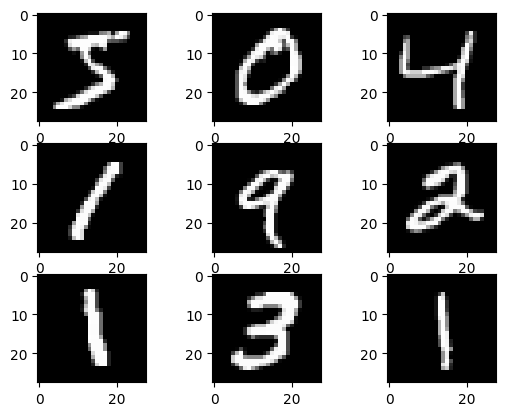

In [29]:
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):
    # Definimos el subplot
    plt.subplot(330 + 1 + i)
    # Pintamos los datos en formato RAW
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))

# Mostrar el dibujo
plt.show()

Como vamos a querer ir haciendo validación a la vez que entrenamos (muy practico)

In [30]:
x_val = x_train[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
y_train = y_train[:-10000]


Cuando añadimos convoluciones, necesitamos "pre-tratar los datos", porque **la convolución es pera una matriz de 4 campos** (más parecido a "imagenes"), no un array de 3 como son actualmente los data sets de train, test y validación. Así que toca darle al **.reshape()**

Por eso, al salir de la Convolution, hay que hacer un Flatten, porque las capas FullDense esperan arrays, no matrices!!

Luego lo imprimimos para ver que todo está correcto

In [31]:
x_train_cnn = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test_cnn = x_test.reshape((x_test.shape[0], 28, 28, 1))
x_val_cnn = x_val.reshape((x_val.shape[0], 28, 28, 1))


print('Train: X=%s, y=%s' % (x_train_cnn.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test_cnn.shape, y_test.shape))
print('Validation: X=%s, y=%s' % (x_val_cnn.shape, y_val.shape))

Train: X=(50000, 28, 28, 1), y=(50000,)
Test: X=(10000, 28, 28, 1), y=(10000,)
Validation: X=(10000, 28, 28, 1), y=(10000,)


## 5. Definamos los callbacks para el Early Stopping



In [32]:
callback_loss = [EarlyStopping(monitor='val_loss', patience=5)]
callback_accuracy = [EarlyStopping(monitor='val_accuracy', patience=5)]

## 6. Entrenamiento

In [33]:
t = time.perf_counter()

In [34]:
history = model.fit(x_train_cnn, y_train, epochs=300,
                    use_multiprocessing=False,
                    validation_data=(x_val_cnn, y_val),
                    batch_size=512,
                    callbacks=(callback_loss, callback_accuracy))

Epoch 1/300
98/98 [==============================] - 4s 34ms/step - loss: 0.7473 - accuracy: 0.7630 - val_loss: 0.2329 - val_accuracy: 0.9324
Epoch 2/300
98/98 [==============================] - 2s 24ms/step - loss: 0.3063 - accuracy: 0.9098 - val_loss: 0.1617 - val_accuracy: 0.9519
Epoch 3/300
98/98 [==============================] - 2s 21ms/step - loss: 0.2374 - accuracy: 0.9295 - val_loss: 0.1335 - val_accuracy: 0.9605
Epoch 4/300
98/98 [==============================] - 2s 20ms/step - loss: 0.1997 - accuracy: 0.9396 - val_loss: 0.1173 - val_accuracy: 0.9648
Epoch 5/300
98/98 [==============================] - 2s 20ms/step - loss: 0.1720 - accuracy: 0.9484 - val_loss: 0.1054 - val_accuracy: 0.9695
Epoch 6/300
98/98 [==============================] - 3s 30ms/step - loss: 0.1568 - accuracy: 0.9526 - val_loss: 0.1020 - val_accuracy: 0.9706
Epoch 7/300
98/98 [==============================] - 3s 26ms/step - loss: 0.1427 - accuracy: 0.9565 - val_loss: 0.0930 - val_accuracy: 0.9733
Epoch 

In [35]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 0:01:17.514198


## 6. Evaluamos los resultados

Obtengamos una grafica de como el error y la accuracy van evolucionando en cada epoch en los datos de entrenamiento y en la validación

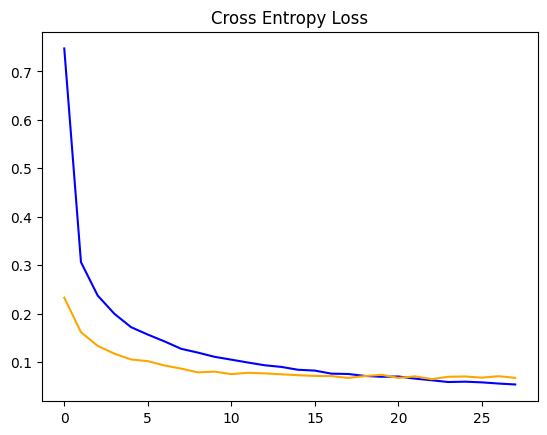

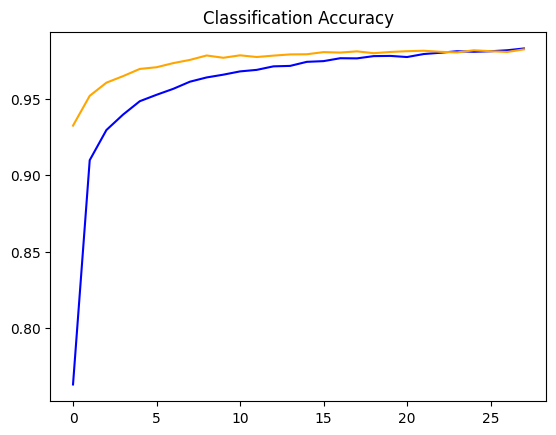

In [36]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')
plt.show()

Evaluemos el modelo contra los valores de testeo

In [37]:
model.evaluate(x_test_cnn,  y_test, verbose=2)

313/313 - 1s - loss: 0.0675 - accuracy: 0.9816 - 766ms/epoch - 2ms/step


[0.0675458014011383, 0.9815999865531921]

El coste podemos ver que es estable y es en el epoch 15 que se fija en un valor. Además la accuracy baila alrededor de 0.10. No se puede decir que sea un modelo muy bueno.

Veamos que tipo de predicciones estoy obteniendo sobre el conjunto de test (vamos a pintar las imagenes y sus clasificaciones)

In [38]:
predictions = model.predict(x_test_cnn)

313/313 [==============================] - 1s 3ms/step


Una de las ventajas de Python es que hay montones de funciones y código realizado por terceras personas. Aquí me he fusilado unas bonitas funciones (que he adaptado un poco a mis necesidades) para poder pintar las imagenes, su label (ground truth) y las clasificaciones que hemos realizado.

In [39]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Dibujamos los primeros digitos, con las predicciones y sus valores reales (un total de 20 imagenes, para no abusar de vuestros laptops)

Coloreamos las prediciones correctas en azul y los fallos en rojo

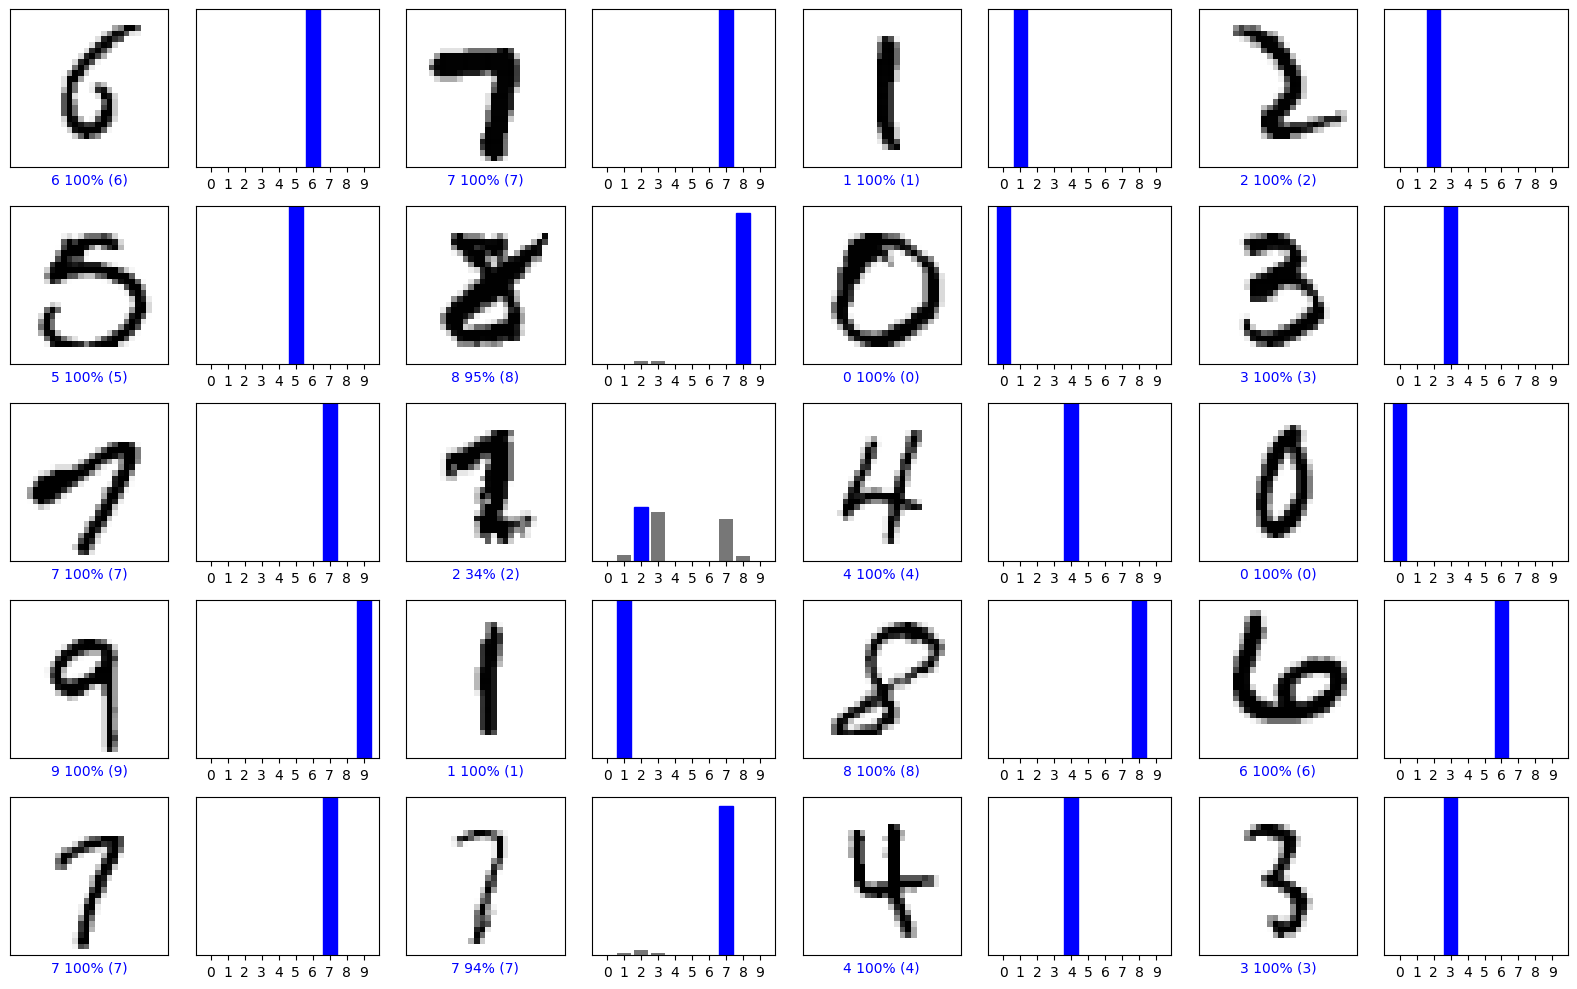

In [40]:
num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()